In [4]:
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_VISIBLE_DEVICES=2


In [5]:
%load_ext autoreload
%autoreload 2
import os
import sys; 
sys.path.extend(['/home/meet/FlowMatchingTests/conditional-flow-matching/'])
sys.path.extend(['..'])

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm
from torchcfm.conditional_flow_matching import *
from physics_flow_matching.unet.unet import GuidedUNetModelWrapper as UNetModel
from physics_flow_matching.inference_scripts.utils import grad_cost_func_parallel, cost_func_parallel, sample_noise
from physics_flow_matching.inference_scripts.cond import infer_parallel
from physics_flow_matching.inference_scripts.uncond import infer
from resdiual import calculate_kuramoto_sivashinsky_residual, two_point_corr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
fid = "high" 
data = np.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/synthetic/ks/{fid}_fid.npy")
test_data = np.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/synthetic/ks/{fid}_fid_test.npy")
m, std = data.mean(axis=(0,2,3), keepdims=True), data.std(axis=(0,2,3), keepdims=True)
X = (test_data - m)/std

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def meas_func(x, **kwargs):
    return x[..., :128, :] # temporal inpainting
    # return x[..., :128] # spatial inpainting

In [9]:
meas = torch.from_numpy(meas_func(X)).to(device)

In [10]:
exp = "lf_hf"
iteration = 9
print(f"Loading model for experiment {exp}, iteration {iteration}")
ot_cfm_model = UNetModel(dim=[1, 256, 256],
                        channel_mult=None,
                        num_channels=128,
                        num_res_blocks=2,
                        num_head_channels=64,
                        attention_resolutions="40",
                        dropout=0.0,
                        use_new_attention_order=True,
                        use_scale_shift_norm=True,
                        guide_func=None
                        )
state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/exps/{exp}/exp_gaussian_ot/saved_state/checkpoint_{iteration}.pth")
ot_cfm_model.load_state_dict(state["model_state_dict"])
ot_cfm_model.to(device)
ot_cfm_model.eval();

Loading model for experiment lf_hf, iteration 9


/tmp/ipykernel_637434/4072541903.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flo

### Grad

In [11]:
total_samples = 100
samples_per_batch = 10

In [12]:
cond = meas[1:2].repeat(total_samples,1,1,1).to(device)
cond += 0.10 * torch.randn_like(cond)

In [13]:
samples_cond_grad = infer_parallel(cfm_model=ot_cfm_model,
                    swag=False, samples_per_batch=samples_per_batch, total_samples=total_samples,
                    dims_of_img=(1,256,256), num_of_steps=300, grad_cost_func=grad_cost_func_parallel, meas_func= meas_func,
                    conditioning=cond, conditioning_scale=1., device=device, refine=1, sample_noise=sample_noise,
                    use_heavy_noise=False, rf_start=False,
                    solver='euler', is_grad_free=False, nu=None)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/meet/.conda/envs/torchcfm/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")
100%|██████████| 10/10 [34:47<00:00, 208.80s/it]


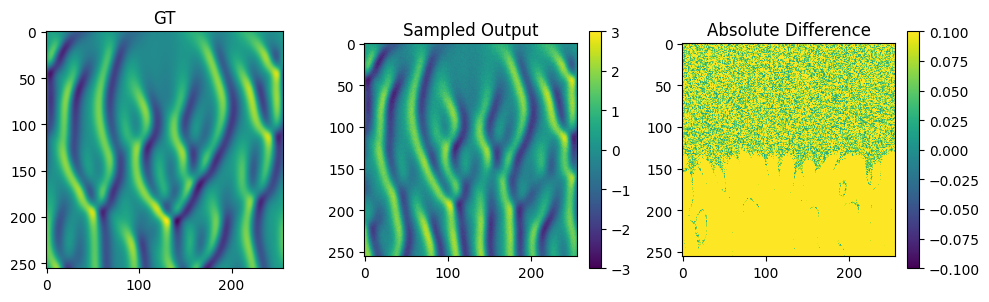

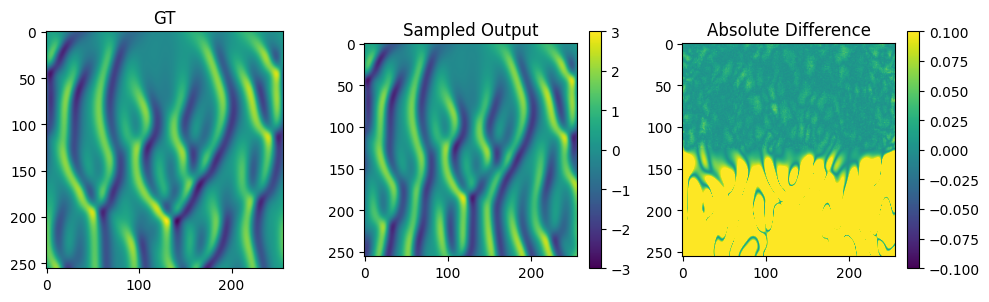

In [14]:
for i in range(2):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(X[1, 0], vmax=3, vmin=-3)
    axes[0].set_title('GT')
    a = axes[1].imshow(samples_cond_grad[i, 0], vmax=3, vmin=-3)
    axes[1].set_title('Sampled Output')
    fig.colorbar(ax=axes[1], mappable=a, fraction = 0.05)
    b = axes[2].imshow(np.abs(X[1, 0] - samples_cond_grad[i, 0]), vmax=0.1, vmin=-0.1)
    axes[2].set_title('Absolute Difference')
    fig.colorbar(ax=axes[2], mappable=b, fraction = 0.05)
    plt.tight_layout()
    plt.show()

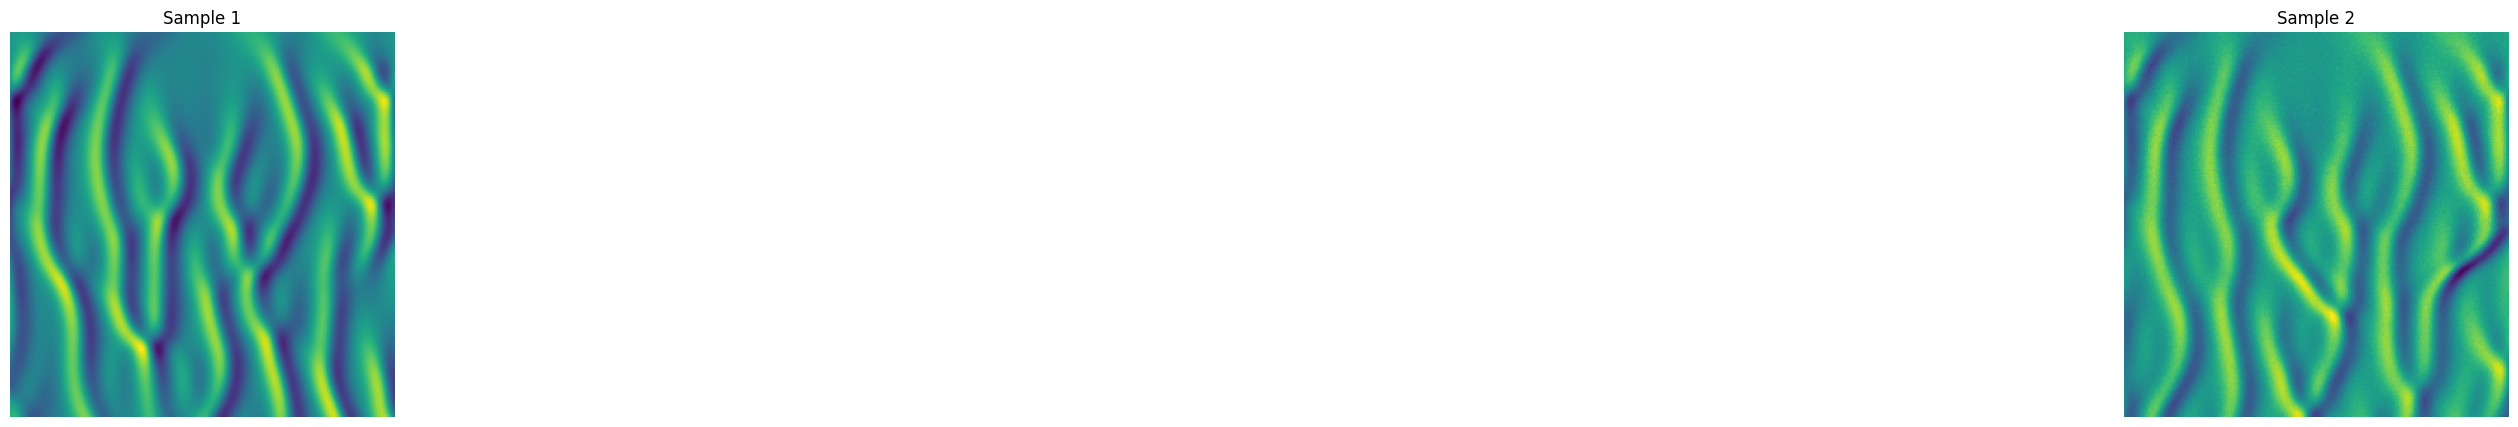

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(50, 5))
for i in range(2):
    axes[i].imshow(samples_cond_grad[i, 0])
    axes[i].set_title(f'Sample {i+1}')
    axes[i].axis('off')

In [15]:
corr_grad = []
for s in (samples_cond_grad):
    corr_grad.append(two_point_corr(s[0], np.arange(256), 0, 1)[-1])

In [16]:
corr_grad = np.stack(corr_grad, axis=0)

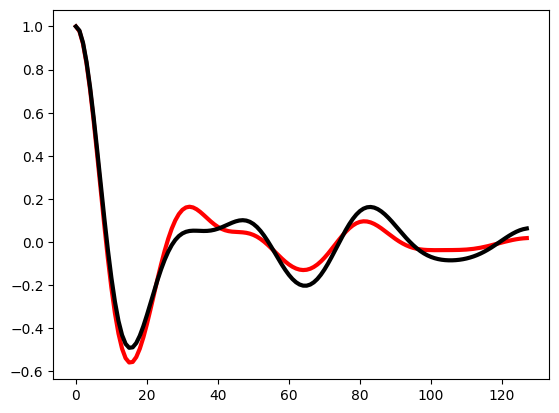

In [17]:
# for i in range(20):
#     plt.plot(np.arange(128), corr_mcmc[i], label='MCMC')
plt.plot(np.arange(128), corr_grad.mean(axis=0), label='MCMC Mean', color='red', linewidth=3)
plt.plot(np.arange(128), two_point_corr(X[1,0], np.arange(256), 0, 1)[-1], label='GT', linewidth=3, color='black')
plt.show()

In [18]:
calculate_kuramoto_sivashinsky_residual((samples_cond_grad * std + m)[:, 0], 0.2,0.245)

array([207.0375   ,   5.5388117,   5.9501157,   6.193588 ,   5.9138594,
       203.72482  , 202.40657  , 207.04533  ,   6.1589327,   6.278678 ,
         6.029962 ,   6.4079747, 202.85799  , 196.32925  ,   6.2215447,
       207.85272  , 206.29912  ,   5.6515794,   5.7549953, 195.9845   ,
         5.728845 ,   6.1428704,   6.2860303,   6.1713257,   6.0995493,
         6.204114 ,   5.5687304,   6.5222564, 195.98996  ,   5.9334908,
         5.7054234,   7.121981 ,   6.1405044,   8.1883955, 194.1593   ,
         5.4638414,   6.2730513,   5.9152417, 194.64366  ,   5.432214 ,
         6.2386317, 205.87872  , 192.37398  ,   6.3263245,   8.902319 ,
         6.073682 ,   5.6457562,   6.1902633,   6.1996965, 204.83705  ,
         5.9965987, 203.94247  ,   6.1712093, 204.95789  ,   5.5342903,
       203.26692  ,   7.0136895, 206.56165  ,   7.172825 , 203.42198  ,
         6.208222 ,   6.1798553,   6.255237 ,   6.3053637,   6.22141  ,
       209.42094  ,   6.3116665,   6.092378 , 189.42447  ,   6.1

In [19]:
np.square((meas[1:2].cpu().numpy() - samples_cond_grad[:1,..., :128, :])).mean()

np.float32(0.009934999)